#### Practical strategies for ships passing limited water depth to achieve multiple goals
- Strategies include vessel sailing velocities, payload adjustment(actual draught), parcial engine load
- multiple goals covers the indicators of fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway). 

##### Steps
- present a waterway section with limited water depth (150 km with 2.5 m water depth) on the graph
- provide a list of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
- use get_v funtion to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed
- for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
- use 'Parallel coordinate plot' to visualise strategies
- Automatically select optimal strategies to achieve the goal of less transport time, less emissions, less fuel use, safety guarantees.

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


#### Present the waterway section with limited water depth on the graph network

In [2]:
# We're in engineering cordinates (m)
coords = [
    [0,0],
    [8.983,0], 
    [17.966,0],
    [17.966,13.566],
    [17.966,22.609],
    [27.527,9.560],
    [33.903,15.931],
    [31.441,0],
    
    [40.424, 0],
    [19.560,-01.693],
    [33.904,-15.931]] 


# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [3]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [4]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        length = round(edge_geometry.length),
        e = tuple(edge)
    )
    FG.add_edge( str(edge[0]), str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

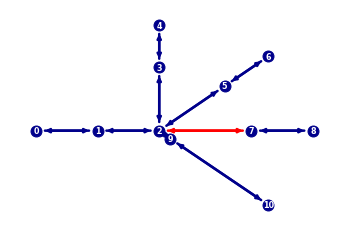

In [7]:
# draw edges, nodes and labels.
colors =['darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue']
nx.draw_networkx_edges(FG,  pos=positions, width=2.5, edge_color=colors, alpha=1, arrowsize=8)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=120)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.savefig('graph_limited_water_dpeth.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()

#### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [8]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [9]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":  None, # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 2.05,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }        
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

In [10]:
draught = opentnsim.strategy.Payload2T(vessel= vessel, Payload_strategy=1056, vessel_type= "Tanker")
draught 

1056 895.7458840285351 1.9098300562505255 Tanker
1056 2257.602101095369 3.0901699437494736 Tanker
1056 71.79021006740653 1.1803398874989486 Tanker
1056 1044.1913180734334 2.0399965091179606 Tanker
1056 1057.716755989075 2.0518377268728565 Tanker
1056 1056.0156290450589 2.0503485999924838 Tanker
1056 1055.9998008493014 2.0503347441269755 Tanker
1056 1056.0036434099507 2.0503381078716876 Tanker
1056 1055.99595828894 2.0503313803822634 Tanker


2.0503347441269755

#### Provide a group of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
here we choose M8 vessel as it has a large share of the sailing movements per year on waal (Rijkswaterstaat,2021, Safety aspects of new energy carriers in inland navigation), M8's draught ranges from 1.4 m to 3.5 m, considering a safety margin (minimum ukc) of 0.2 m at water depth 2.5 m, the final feasible draught ranges from 1.4 m to 2.3 m.

In [11]:
# provide max and min draught
max_draught = 2.30
min_operational_draught = 1.40
stepsize = -0.05

# create lists of strategy values
T_strategy = np.arange(max_draught, round(min_operational_draught + stepsize, 2), stepsize).round(2).tolist()
h_min = [2.5]
safety_margin = [0.2]
width = [150]

In [12]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(20)

,T_strategy,h_min,safety_margin,width
0,2.30,2.5,0.2,150
1,2.25,2.5,0.2,150
2,2.20,2.5,0.2,150
3,2.15,2.5,0.2,150
4,2.10,2.5,0.2,150
5,2.05,2.5,0.2,150
6,2.00,2.5,0.2,150
7,1.95,2.5,0.2,150
8,1.90,2.5,0.2,150
9,1.85,2.5,0.2,150


#### Caculate the maximum velocity the vessel can sail at for each T_strategy, considering maximum sinkage and installed engine power

In [13]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    # detaremine payload
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound # power allowed max v   
    Strategy['v_strategy (m/s)'] = v  # final max v considering squat and installed power
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

In [14]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,2.30,2.50,0.20,150.00,2.90,0.00,0.00,2.50,2.50,1342.00
1,2.25,2.50,0.20,150.00,3.23,1.58,0.05,2.45,2.45,1284.59
2,2.20,2.50,0.20,150.00,3.44,2.23,0.10,2.40,2.40,1227.25
3,2.15,2.50,0.20,150.00,3.57,2.73,0.15,2.35,2.35,1169.98
4,2.10,2.50,0.20,150.00,3.58,3.17,0.20,2.30,2.30,1112.77
5,2.05,2.50,0.20,150.00,3.63,3.56,0.25,2.25,2.25,1055.62
6,2.00,2.50,0.20,150.00,3.65,3.65,0.26,2.24,2.20,998.53
7,1.95,2.50,0.20,150.00,3.65,3.65,0.25,2.25,2.15,941.51
8,1.90,2.50,0.20,150.00,3.62,3.62,0.24,2.26,2.10,884.55
9,1.85,2.50,0.20,150.00,3.62,3.62,0.24,2.26,2.05,827.66


#### Provide a group of feasible velocities for each T_strategy

In [15]:
# provide max and min draught
v_feasible_forT = []
for row in Strategies:
    max_velocity = row['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    # create lists of strategy values
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2).tolist()
    v_feasible_forT.append(v_feasible)
v_df = pd.DataFrame(v_feasible_forT).T
names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
v_df.columns=names
v_df

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,NaN,1.58,2.23,2.73,3.17,3.56,3.65,3.65,3.62,3.62,3.6,3.57,3.59,3.6,3.53,3.59,3.57,3.53,3.41
1,NaN,1.48,2.13,2.63,3.07,3.46,3.55,3.55,3.52,3.52,3.5,3.47,3.49,3.5,3.43,3.49,3.47,3.43,3.31
2,NaN,1.38,2.03,2.53,2.97,3.36,3.45,3.45,3.42,3.42,3.4,3.37,3.39,3.4,3.33,3.39,3.37,3.33,3.21
3,NaN,1.28,1.93,2.43,2.87,3.26,3.35,3.35,3.32,3.32,3.3,3.27,3.29,3.3,3.23,3.29,3.27,3.23,3.11
4,NaN,1.18,1.83,2.33,2.77,3.16,3.25,3.25,3.22,3.22,3.2,3.17,3.19,3.2,3.13,3.19,3.17,3.13,3.01
5,NaN,1.08,1.73,2.23,2.67,3.06,3.15,3.15,3.12,3.12,3.1,3.07,3.09,3.1,3.03,3.09,3.07,3.03,2.91
6,NaN,0.98,1.63,2.13,2.57,2.96,3.05,3.05,3.02,3.02,3.0,2.97,2.99,3.0,2.93,2.99,2.97,2.93,2.81
7,NaN,NaN,1.53,2.03,2.47,2.86,2.95,2.95,2.92,2.92,2.9,2.87,2.89,2.9,2.83,2.89,2.87,2.83,2.71
8,NaN,NaN,1.43,1.93,2.37,2.76,2.85,2.85,2.82,2.82,2.8,2.77,2.79,2.8,2.73,2.79,2.77,2.73,2.61
9,NaN,NaN,1.33,1.83,2.27,2.66,2.75,2.75,2.72,2.72,2.7,2.67,2.69,2.7,2.63,2.69,2.67,2.63,2.51


In [16]:
T_strategy = pd.DataFrame(T_strategy).T 
T_names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
T_strategy.columns = T_names
T_strategy

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,2.3,2.25,2.2,2.15,2.1,2.05,2.0,1.95,1.9,1.85,1.8,1.75,1.7,1.65,1.6,1.55,1.5,1.45,1.4


In [17]:
# prepare the work to be done by creating a list of all combinations

work1 = list(itertools.product(T_strategy['T=2.25'], v_df['T=2.25'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work1:
    row = {"T=2.25": item[0],"v_feasible_forT=2.25":item[1], "h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work1_df = pd.DataFrame(rows)
work1_df = work1_df.dropna(axis=0, how = 'any')
work1_df

,T=2.25,v_feasible_forT=2.25,h_min,safety_margin,width
0,2.25,1.58,2.5,0.2,150
1,2.25,1.48,2.5,0.2,150
2,2.25,1.38,2.5,0.2,150
3,2.25,1.28,2.5,0.2,150
4,2.25,1.18,2.5,0.2,150
5,2.25,1.08,2.5,0.2,150
6,2.25,0.98,2.5,0.2,150


In [18]:
# prepare the work to be done by creating a list of all combinations
work2 = list(itertools.product(T_strategy['T=2.20'], v_df['T=2.20'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work2:
    row = {"T=2.20": item[0],"v_feasible_forT=2.20":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work2_df = pd.DataFrame(rows)
work2_df = work2_df.dropna(axis=0, how = 'any')
work2_df.head(3)

,T=2.20,v_feasible_forT=2.20,h_min,safety_margin,width
0,2.2,2.23,2.5,0.2,150
1,2.2,2.13,2.5,0.2,150
2,2.2,2.03,2.5,0.2,150


In [19]:
# prepare the work to be done by creating a list of all combinations
work3 = list(itertools.product(T_strategy['T=2.15'], v_df['T=2.15'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work3:
    row = {"T=2.15": item[0],"v_feasible_forT=2.15":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work3_df = pd.DataFrame(rows)
work3_df = work3_df.dropna(axis=0, how = 'any')
work3_df.head(3)

,T=2.15,v_feasible_forT=2.15,h_min,safety_margin,width
0,2.15,2.73,2.5,0.2,150
1,2.15,2.63,2.5,0.2,150
2,2.15,2.53,2.5,0.2,150


In [20]:
# prepare the work to be done by creating a list of all combinations
work4 = list(itertools.product(T_strategy['T=2.10'], v_df['T=2.10'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work4:
    row = {"T=2.10": item[0],"v_feasible_forT=2.10":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work4_df = pd.DataFrame(rows)
work4_df = work4_df.dropna(axis=0, how = 'any')
work4_df.head(3)

,T=2.10,v_feasible_forT=2.10,h_min,safety_margin,width
0,2.1,3.17,2.5,0.2,150
1,2.1,3.07,2.5,0.2,150
2,2.1,2.97,2.5,0.2,150


In [21]:
# prepare the work to be done by creating a list of all combinations
work5 = list(itertools.product(T_strategy['T=2.05'], v_df['T=2.05'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work5:
    row = {"T=2.05": item[0],"v_feasible_forT=2.05":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work5_df = pd.DataFrame(rows)
work5_df = work5_df.dropna(axis=0, how = 'any')
work5_df.head(3)

,T=2.05,v_feasible_forT=2.05,h_min,safety_margin,width
0,2.05,3.56,2.5,0.2,150
1,2.05,3.46,2.5,0.2,150
2,2.05,3.36,2.5,0.2,150


In [22]:
# prepare the work to be done by creating a list of all combinations
work6 = list(itertools.product(T_strategy['T=2.00'], v_df['T=2.00'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work6:
    row = {"T=2.00": item[0],"v_feasible_forT=2.00":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work6_df = pd.DataFrame(rows)
work6_df = work6_df.dropna(axis=0, how = 'any')
work6_df.head(3)

,T=2.00,v_feasible_forT=2.00,h_min,safety_margin,width
0,2.0,3.65,2.5,0.2,150
1,2.0,3.55,2.5,0.2,150
2,2.0,3.45,2.5,0.2,150


In [23]:
# prepare the work to be done by creating a list of all combinations
work7 = list(itertools.product(T_strategy['T=1.95'], v_df['T=1.95'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work7:
    row = {"T=1.95": item[0],"v_feasible_forT=1.95":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work7_df = pd.DataFrame(rows)
work7_df = work7_df.dropna(axis=0, how = 'any')
work7_df.head(3)

,T=1.95,v_feasible_forT=1.95,h_min,safety_margin,width
0,1.95,3.65,2.5,0.2,150
1,1.95,3.55,2.5,0.2,150
2,1.95,3.45,2.5,0.2,150


In [24]:
# prepare the work to be done by creating a list of all combinations
work8 = list(itertools.product(T_strategy['T=1.90'], v_df['T=1.90'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work8:
    row = {"T=1.90": item[0],"v_feasible_forT=1.90":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work8_df = pd.DataFrame(rows)
work8_df = work8_df.dropna(axis=0, how = 'any')
work8_df.head(3)

,T=1.90,v_feasible_forT=1.90,h_min,safety_margin,width
0,1.9,3.62,2.5,0.2,150
1,1.9,3.52,2.5,0.2,150
2,1.9,3.42,2.5,0.2,150


In [25]:
# prepare the work to be done by creating a list of all combinations
work9 = list(itertools.product(T_strategy['T=1.85'], v_df['T=1.85'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work9:
    row = {"T=1.85": item[0],"v_feasible_forT=1.85":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work9_df = pd.DataFrame(rows)
work9_df = work9_df.dropna(axis=0, how = 'any')
work9_df.head(3)

,T=1.85,v_feasible_forT=1.85,h_min,safety_margin,width
0,1.85,3.62,2.5,0.2,150
1,1.85,3.52,2.5,0.2,150
2,1.85,3.42,2.5,0.2,150


In [26]:
# prepare the work to be done by creating a list of all combinations
work10 = list(itertools.product(T_strategy['T=1.80'], v_df['T=1.80'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work10:
    row = {"T=1.80": item[0],"v_feasible_forT=1.80":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work10_df = pd.DataFrame(rows)
work10_df = work10_df.dropna(axis=0, how = 'any')
work10_df.head(3)

,T=1.80,v_feasible_forT=1.80,h_min,safety_margin,width
0,1.8,3.6,2.5,0.2,150
1,1.8,3.5,2.5,0.2,150
2,1.8,3.4,2.5,0.2,150


In [27]:
# prepare the work to be done by creating a list of all combinations
work11 = list(itertools.product(T_strategy['T=1.75'], v_df['T=1.75'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work11:
    row = {"T=1.75": item[0],"v_feasible_forT=1.75":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work11_df = pd.DataFrame(rows)
work11_df = work11_df.dropna(axis=0, how = 'any')
work11_df.head(3)

,T=1.75,v_feasible_forT=1.75,h_min,safety_margin,width
0,1.75,3.57,2.5,0.2,150
1,1.75,3.47,2.5,0.2,150
2,1.75,3.37,2.5,0.2,150


In [28]:
# prepare the work to be done by creating a list of all combinations
work12 = list(itertools.product(T_strategy['T=1.70'], v_df['T=1.70'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work12:
    row = {"T=1.70": item[0],"v_feasible_forT=1.70":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work12_df = pd.DataFrame(rows)
work12_df = work12_df.dropna(axis=0, how = 'any')
work12_df.head(3)

,T=1.70,v_feasible_forT=1.70,h_min,safety_margin,width
0,1.7,3.59,2.5,0.2,150
1,1.7,3.49,2.5,0.2,150
2,1.7,3.39,2.5,0.2,150


In [29]:
# prepare the work to be done by creating a list of all combinations
work13 = list(itertools.product(T_strategy['T=1.65'], v_df['T=1.65'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work13:
    row = {"T=1.65": item[0],"v_feasible_forT=1.65":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work13_df = pd.DataFrame(rows)
work13_df = work13_df.dropna(axis=0, how = 'any')
work13_df.head(3)

,T=1.65,v_feasible_forT=1.65,h_min,safety_margin,width
0,1.65,3.6,2.5,0.2,150
1,1.65,3.5,2.5,0.2,150
2,1.65,3.4,2.5,0.2,150


In [30]:
# prepare the work to be done by creating a list of all combinations
work14 = list(itertools.product(T_strategy['T=1.60'], v_df['T=1.60'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work14:
    row = {"T=1.60": item[0],"v_feasible_forT=1.60":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work14_df = pd.DataFrame(rows)
work14_df = work14_df.dropna(axis=0, how = 'any')
work14_df.head(3)

,T=1.60,v_feasible_forT=1.60,h_min,safety_margin,width
0,1.6,3.53,2.5,0.2,150
1,1.6,3.43,2.5,0.2,150
2,1.6,3.33,2.5,0.2,150


In [31]:
# prepare the work to be done by creating a list of all combinations
work15 = list(itertools.product(T_strategy['T=1.55'], v_df['T=1.55'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work15:
    row = {"T=1.55": item[0],"v_feasible_forT=1.55":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work15_df = pd.DataFrame(rows)
work15_df = work15_df.dropna(axis=0, how = 'any')
work15_df.head(3)

,T=1.55,v_feasible_forT=1.55,h_min,safety_margin,width
0,1.55,3.59,2.5,0.2,150
1,1.55,3.49,2.5,0.2,150
2,1.55,3.39,2.5,0.2,150


In [32]:
# prepare the work to be done by creating a list of all combinations
work16 = list(itertools.product(T_strategy['T=1.50'], v_df['T=1.50'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work16:
    row = {"T=1.50": item[0],"v_feasible_forT=1.50":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work16_df = pd.DataFrame(rows)
work16_df = work16_df.dropna(axis=0, how = 'any')
work16_df.head(3)

,T=1.50,v_feasible_forT=1.50,h_min,safety_margin,width
0,1.5,3.57,2.5,0.2,150
1,1.5,3.47,2.5,0.2,150
2,1.5,3.37,2.5,0.2,150


In [33]:
# prepare the work to be done by creating a list of all combinations
work17 = list(itertools.product(T_strategy['T=1.45'], v_df['T=1.45'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work17:
    row = {"T=1.45": item[0],"v_feasible_forT=1.45":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work17_df = pd.DataFrame(rows)
work17_df = work17_df.dropna(axis=0, how = 'any')
work17_df.head(3)

,T=1.45,v_feasible_forT=1.45,h_min,safety_margin,width
0,1.45,3.53,2.5,0.2,150
1,1.45,3.43,2.5,0.2,150
2,1.45,3.33,2.5,0.2,150


In [34]:
# prepare the work to be done by creating a list of all combinations
work18 = list(itertools.product(T_strategy['T=1.40'], v_df['T=1.40'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work18:
    row = {"T=1.40": item[0],"v_feasible_forT=1.40":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work18_df = pd.DataFrame(rows)
work18_df = work18_df.dropna(axis=0, how = 'any')
work18_df.head(3)

,T=1.40,v_feasible_forT=1.40,h_min,safety_margin,width
0,1.4,3.41,2.5,0.2,150
1,1.4,3.31,2.5,0.2,150
2,1.4,3.21,2.5,0.2,150


#### for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
 indicators: fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway)

In [35]:
def run_simulation(V_s, T):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

In [36]:
path = nx.dijkstra_path(FG, nodes[2].name, nodes[7].name)

In [37]:
Strategies1 = []
for i, row in tqdm.tqdm(work1_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.25']) / (row['width'] * row['h_min'])) ** 0.81) * (
        (row['v_feasible_forT=2.25']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.25'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.25'],T = row['T=2.25'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.25'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies1.append(Strategy)
    
Strategies1_df= pd.DataFrame(Strategies1)
Strategies1_df['transport time (hours)'] = (Strategies1_df['transport time (s)'].str[0])/3600
Strategies1_df['Fuel Use (ton)'] = (Strategies1_df['Fuel Use (g)'].str[0])/1000000
Strategies1_df['CO2 (ton)'] = (Strategies1_df['CO2 (g)'].str[0])/1000000
Strategies1_df['PM10 (kg)'] = (Strategies1_df['PM10 (g)'].str[0])/1000
Strategies1_df['NOx (kg)'] = (Strategies1_df['NOx (g)'].str[0])/1000
Strategies1_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=2.25,v_feasible_forT=2.25,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,2.25,1.58,0.200270,1284.593609,263.718379,10.066068,30.792653,28.583541,565.062232
1,2.25,1.48,0.206593,1284.593609,281.537188,10.081029,30.838421,29.707919,582.004950
2,2.25,1.38,0.212472,1284.593609,301.938434,10.194009,31.184032,30.976094,602.447538
3,2.25,1.28,0.217907,1284.593609,325.527374,10.418007,31.869255,32.469749,627.786104
4,2.25,1.18,0.222903,1284.593609,353.114439,10.771558,32.950785,34.281781,659.660385
5,2.25,1.08,0.227461,1284.593609,385.810221,11.281015,34.509243,36.525826,700.127320
6,2.25,0.98,0.231585,1284.593609,425.178611,11.984319,36.660689,39.350384,751.923413


In [38]:
Strategies2 = []
for i, row in tqdm.tqdm(work2_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.20']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.20']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.20'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.20'],T = row['T=2.20'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.20'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies2.append(Strategy)
    
Strategies2_df= pd.DataFrame(Strategies2)
Strategies2_df['transport time (hours)'] = (Strategies2_df['transport time (s)'].str[0])/3600
Strategies2_df['Fuel Use (ton)'] = (Strategies2_df['Fuel Use (g)'].str[0])/1000000
Strategies2_df['CO2 (ton)'] = (Strategies2_df['CO2 (g)'].str[0])/1000000
Strategies2_df['PM10 (kg)'] = (Strategies2_df['PM10 (g)'].str[0])/1000
Strategies2_df['NOx (kg)'] = (Strategies2_df['NOx (g)'].str[0])/1000
Strategies2_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=2.20,v_feasible_forT=2.20,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,2.2,2.23,0.200004,1227.254179,186.849793,11.046108,33.790648,24.005979,514.835881
1,2.2,2.13,0.209106,1227.254179,195.622084,10.651338,32.583025,24.026977,507.696292
2,2.2,2.03,0.217757,1227.254179,205.258640,10.341828,31.636218,24.057025,502.272708
3,2.2,1.93,0.225960,1227.254179,215.893802,10.098214,30.890992,24.599873,506.215422
4,2.2,1.83,0.233717,1227.254179,227.691278,9.907987,30.309076,25.674740,519.575061
5,2.2,1.73,0.241028,1227.254179,240.852623,9.784474,29.931243,26.677801,532.791325
6,2.2,1.63,0.247898,1227.254179,255.628858,9.731712,29.769839,27.678628,546.955708
7,2.2,1.53,0.254326,1227.254179,272.336626,9.755833,29.843627,28.742726,563.128271
8,2.2,1.43,0.260317,1227.254179,291.381146,9.865540,30.179229,29.935751,582.406940
9,2.2,1.33,0.265871,1227.254179,313.289503,10.072856,30.813418,31.327961,606.004193


In [39]:
Strategies3 = []
for i, row in tqdm.tqdm(work3_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.15']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.15']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.15'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.15'],T = row['T=2.15'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.15'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies3.append(Strategy)
    
Strategies3_df= pd.DataFrame(Strategies3)
Strategies3_df['transport time (hours)'] = (Strategies3_df['transport time (s)'].str[0])/3600
Strategies3_df['Fuel Use (ton)'] = (Strategies3_df['Fuel Use (g)'].str[0])/1000000
Strategies3_df['CO2 (ton)'] = (Strategies3_df['CO2 (g)'].str[0])/1000000
Strategies3_df['PM10 (kg)'] = (Strategies3_df['PM10 (g)'].str[0])/1000
Strategies3_df['NOx (kg)'] = (Strategies3_df['NOx (g)'].str[0])/1000
Strategies3_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=2.15,v_feasible_forT=2.15,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,2.15,2.73,0.200501,1169.978336,152.628219,13.404866,41.006219,24.707090,571.673524
1,2.15,2.63,0.211667,1169.978336,158.431574,12.568260,38.446997,23.915308,543.901662
2,2.15,2.53,0.222383,1169.978336,164.693691,11.880281,36.342432,23.183086,520.208825
3,2.15,2.43,0.232651,1169.978336,171.471209,11.310137,34.598330,23.175077,509.146389
4,2.15,2.33,0.242472,1169.978336,178.830489,10.837558,33.152684,23.264289,501.420437
5,2.15,2.23,0.251849,1169.978336,186.849793,10.449618,31.965953,23.301218,494.613099
6,2.15,2.13,0.260783,1169.978336,195.622084,10.138487,31.014186,23.332115,489.169967
7,2.15,2.03,0.269274,1169.978336,205.258640,9.900331,30.285656,23.419670,485.904510
8,2.15,1.93,0.277326,1169.978336,215.893802,9.722864,29.742774,24.494444,499.439757
9,2.15,1.83,0.284939,1169.978336,227.691278,9.583509,29.316481,25.475551,512.109518


In [40]:
Strategies4 = []
for i, row in tqdm.tqdm(work4_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.10']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.10']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.10'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.10'],T = row['T=2.10'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.10'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies4.append(Strategy)
    
Strategies4_df= pd.DataFrame(Strategies4)
Strategies4_df['transport time (hours)'] = (Strategies4_df['transport time (s)'].str[0])/3600
Strategies4_df['Fuel Use (ton)'] = (Strategies4_df['Fuel Use (g)'].str[0])/1000000
Strategies4_df['CO2 (ton)'] = (Strategies4_df['CO2 (g)'].str[0])/1000000
Strategies4_df['PM10 (kg)'] = (Strategies4_df['PM10 (g)'].str[0])/1000
Strategies4_df['NOx (kg)'] = (Strategies4_df['NOx (g)'].str[0])/1000
Strategies4_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=2.10,v_feasible_forT=2.10,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,2.1,3.17,0.199855,1112.766079,131.443230,19.491989,59.627063,32.987420,813.815831
1,2.1,3.07,0.212764,1112.766079,135.724768,17.141290,52.436145,29.422610,711.185060
2,2.1,2.97,0.225227,1112.766079,140.294626,15.366690,47.007547,26.889267,640.081721
3,2.1,2.87,0.237244,1112.766079,145.182940,13.997839,42.820157,25.165245,590.238023
4,2.1,2.77,0.248818,1112.766079,150.424202,12.964276,39.658430,24.047229,554.487990
5,2.1,2.67,0.259949,1112.766079,156.058067,12.160120,37.198472,23.255998,527.475452
6,2.1,2.57,0.270639,1112.766079,162.130365,11.508167,35.204112,22.544806,504.840820
7,2.1,2.47,0.280889,1112.766079,168.694348,10.973534,33.568641,22.669095,496.347368
8,2.1,2.37,0.290700,1112.766079,175.812253,10.533422,32.222314,22.741852,489.019932
9,2.1,2.27,0.300075,1112.766079,183.557286,10.173512,31.121330,22.775170,482.692384


In [41]:
Strategies5 = []
for i, row in tqdm.tqdm(work5_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.05']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.05']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.05'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.05'],T = row['T=2.05'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.05'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies5.append(Strategy)
    
Strategies5_df= pd.DataFrame(Strategies5)
Strategies5_df['transport time (hours)'] = (Strategies5_df['transport time (s)'].str[0])/3600
Strategies5_df['Fuel Use (ton)'] = (Strategies5_df['Fuel Use (g)'].str[0])/1000000
Strategies5_df['CO2 (ton)'] = (Strategies5_df['CO2 (g)'].str[0])/1000000
Strategies5_df['PM10 (kg)'] = (Strategies5_df['PM10 (g)'].str[0])/1000
Strategies5_df['NOx (kg)'] = (Strategies5_df['NOx (g)'].str[0])/1000
Strategies5_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=2.05,v_feasible_forT=2.05,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,2.05,3.56,0.200149,1055.617409,117.043550,36.567783,111.862854,62.822691,1575.774746
1,2.05,3.46,0.214526,1055.617409,120.426312,30.682036,93.858029,52.726132,1325.746923
2,2.05,3.36,0.228461,1055.617409,124.010428,25.179970,77.026907,42.767820,1071.804899
3,2.05,3.26,0.241955,1055.617409,127.814429,21.310003,65.188467,35.966700,897.373051
4,2.05,3.16,0.255009,1055.617409,131.859189,18.408087,56.311348,31.293739,765.616783
5,2.05,3.06,0.267625,1055.617409,136.168313,16.198746,49.552851,27.992221,672.369954
6,2.05,2.96,0.279803,1055.617409,140.768594,14.538783,44.474933,25.776772,609.189569
7,2.05,2.86,0.291545,1055.617409,145.690573,13.275104,40.609270,24.151411,562.803809
8,2.05,2.76,0.302852,1055.617409,150.969217,12.345573,37.765784,23.282734,532.063683
9,2.05,2.66,0.313724,1055.617409,156.644751,11.611638,35.520636,22.504766,506.821548


In [42]:
Strategies6 = []
for i, row in tqdm.tqdm(work6_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.00']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.00']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.00'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.00'],T = row['T=2.00'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.00'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies6.append(Strategy)
    
Strategies6_df= pd.DataFrame(Strategies6)
Strategies6_df['transport time (hours)'] = (Strategies6_df['transport time (s)'].str[0])/3600
Strategies6_df['Fuel Use (ton)'] = (Strategies6_df['Fuel Use (g)'].str[0])/1000000
Strategies6_df['CO2 (ton)'] = (Strategies6_df['CO2 (g)'].str[0])/1000000
Strategies6_df['PM10 (kg)'] = (Strategies6_df['PM10 (g)'].str[0])/1000
Strategies6_df['NOx (kg)'] = (Strategies6_df['NOx (g)'].str[0])/1000
Strategies6_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=2.00,v_feasible_forT=2.00,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,2.0,3.65,0.242043,998.532325,114.157545,46.182027,141.273351,76.990365,1944.006708
1,2.0,3.55,0.256526,998.532325,117.373250,34.505447,105.554053,59.283533,1491.994435
2,2.0,3.45,0.270574,998.532325,120.775373,29.363994,89.826068,50.432645,1261.572748
3,2.0,3.35,0.284190,998.532325,124.380608,24.238073,74.145594,40.998325,1031.882046
4,2.0,3.25,0.297374,998.532325,128.207704,20.521430,62.776180,34.644677,861.435564
5,2.0,3.15,0.310126,998.532325,132.277790,17.683187,54.093837,30.150877,733.594272
6,2.0,3.05,0.322449,998.532325,136.614767,15.568025,47.623443,27.022508,646.376670
7,2.0,2.95,0.334344,998.532325,141.245776,13.966513,42.724328,24.985345,587.596276
8,2.0,2.85,0.345810,998.532325,146.201768,12.781356,39.098870,23.594929,545.473440
9,2.0,2.75,0.356850,998.532325,151.518196,11.898790,36.399050,22.706608,515.616862


In [43]:
Strategies7 = []
for i, row in tqdm.tqdm(work7_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.95']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.95']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.95'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.95'],T = row['T=1.95'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.95'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies7.append(Strategy)
    
Strategies7_df= pd.DataFrame(Strategies7)    
Strategies7_df['transport time (hours)'] = (Strategies7_df['transport time (s)'].str[0])/3600
Strategies7_df['Fuel Use (ton)'] = (Strategies7_df['Fuel Use (g)'].str[0])/1000000
Strategies7_df['CO2 (ton)'] = (Strategies7_df['CO2 (g)'].str[0])/1000000
Strategies7_df['PM10 (kg)'] = (Strategies7_df['PM10 (g)'].str[0])/1000
Strategies7_df['NOx (kg)'] = (Strategies7_df['NOx (g)'].str[0])/1000
Strategies7_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.95,v_feasible_forT=1.95,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.95,3.65,0.297279,941.510827,114.157545,46.180745,141.269431,76.988228,1943.952767
1,1.95,3.55,0.311468,941.510827,117.373250,34.222454,104.688363,58.799001,1477.684550
2,1.95,3.45,0.325231,941.510827,120.775373,29.130853,89.112876,49.979765,1251.595986
3,1.95,3.35,0.338571,941.510827,124.380608,24.029712,73.508205,40.611775,1023.045631
4,1.95,3.25,0.351487,941.510827,128.207704,20.298948,62.095595,34.271334,851.405517
5,1.95,3.15,0.363981,941.510827,132.277790,17.431234,53.323101,29.765778,722.975174
6,1.95,3.05,0.376053,941.510827,136.614767,15.298991,46.800451,26.629683,635.753512
7,1.95,2.95,0.387706,941.510827,141.245776,13.687023,41.869353,24.582623,576.877253
8,1.95,2.85,0.398940,941.510827,146.201768,12.511397,38.273050,23.261307,535.688507
9,1.95,2.75,0.409756,941.510827,151.518196,11.634937,35.591910,22.341171,505.638407


In [44]:
Strategies8 = []
for i, row in tqdm.tqdm(work8_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.90']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.90']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.90'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.90'],T = row['T=1.90'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.90'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies8.append(Strategy)
    
Strategies8_df= pd.DataFrame(Strategies8)
Strategies8_df['transport time (hours)'] = (Strategies8_df['transport time (s)'].str[0])/3600
Strategies8_df['Fuel Use (ton)'] = (Strategies8_df['Fuel Use (g)'].str[0])/1000000
Strategies8_df['CO2 (ton)'] = (Strategies8_df['CO2 (g)'].str[0])/1000000
Strategies8_df['PM10 (kg)'] = (Strategies8_df['PM10 (g)'].str[0])/1000
Strategies8_df['NOx (kg)'] = (Strategies8_df['NOx (g)'].str[0])/1000
Strategies8_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.90,v_feasible_forT=1.90,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.9,3.62,0.356753,884.552916,115.103602,45.623313,139.564214,76.058929,1920.487952
1,1.9,3.52,0.370521,884.552916,118.373590,32.438663,99.231646,55.740208,1399.056454
2,1.9,3.42,0.383873,884.552916,121.834807,26.844513,82.118836,45.693066,1150.086126
3,1.9,3.32,0.396810,884.552916,125.504530,22.538481,68.946450,38.020365,955.148685
4,1.9,3.22,0.409333,884.552916,129.402186,19.209654,58.763386,32.506905,802.084575
5,1.9,3.12,0.421443,884.552916,133.549692,16.618465,50.836795,28.574420,689.569603
6,1.9,3.02,0.433141,884.552916,137.971867,14.611502,44.697386,25.764935,610.732103
7,1.9,2.92,0.444428,884.552916,142.696931,13.108681,40.100174,23.778272,555.006484
8,1.9,2.82,0.455305,884.552916,147.757106,12.035664,36.817757,22.725024,518.989348
9,1.9,2.72,0.465774,884.552916,153.189352,11.221159,34.326140,21.813719,490.470987


In [45]:
Strategies9 = []
for i, row in tqdm.tqdm(work9_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.85']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.85']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.85'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.85'],T = row['T=1.85'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.85'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies9.append(Strategy)
    
Strategies9_df= pd.DataFrame(Strategies9)
Strategies9_df['transport time (hours)'] = (Strategies9_df['transport time (s)'].str[0])/3600
Strategies9_df['Fuel Use (ton)'] = (Strategies9_df['Fuel Use (g)'].str[0])/1000000
Strategies9_df['CO2 (ton)'] = (Strategies9_df['CO2 (g)'].str[0])/1000000
Strategies9_df['PM10 (kg)'] = (Strategies9_df['PM10 (g)'].str[0])/1000
Strategies9_df['NOx (kg)'] = (Strategies9_df['NOx (g)'].str[0])/1000
Strategies9_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.85,v_feasible_forT=1.85,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.85,3.62,0.411951,827.658592,115.103602,46.100375,141.023574,76.854243,1940.569628
1,1.85,3.52,0.425425,827.658592,118.373590,32.846238,100.478443,56.440556,1414.176951
2,1.85,3.42,0.438492,827.658592,121.834807,27.039475,82.715237,46.023764,1159.410631
3,1.85,3.32,0.451152,827.658592,125.504530,22.658064,69.312260,38.220573,960.681077
4,1.85,3.22,0.463408,827.658592,129.402186,19.271931,58.953893,32.603975,804.858960
5,1.85,3.12,0.475259,827.658592,133.549692,16.617565,50.834043,28.573051,689.532549
6,1.85,3.02,0.486707,827.658592,137.971867,14.551419,44.513589,25.682374,608.470688
7,1.85,2.92,0.497753,827.658592,142.696931,13.011047,39.801505,23.665201,551.547754
8,1.85,2.82,0.508397,827.658592,147.757106,11.910990,36.436371,22.559292,514.347544
9,1.85,2.72,0.518642,827.658592,153.189352,11.081553,33.899078,21.609508,485.076916


In [46]:
Strategies10 = []
for i, row in tqdm.tqdm(work10_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.80']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.80']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.80'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.80'],T = row['T=1.80'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.80'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies10.append(Strategy)
    
Strategies10_df= pd.DataFrame(Strategies10)
Strategies10_df['transport time (hours)'] = (Strategies10_df['transport time (s)'].str[0])/3600
Strategies10_df['Fuel Use (ton)'] = (Strategies10_df['Fuel Use (g)'].str[0])/1000000
Strategies10_df['CO2 (ton)'] = (Strategies10_df['CO2 (g)'].str[0])/1000000
Strategies10_df['PM10 (kg)'] = (Strategies10_df['PM10 (g)'].str[0])/1000
Strategies10_df['NOx (kg)'] = (Strategies10_df['NOx (g)'].str[0])/1000
Strategies10_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.80,v_feasible_forT=1.80,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.8,3.6,0.469843,770.827854,115.743066,43.778008,133.919326,73.241781,1849.354964
1,1.8,3.5,0.482942,770.827854,119.050011,32.969878,100.856663,56.653010,1419.885726
2,1.8,3.4,0.495642,770.827854,122.551482,26.499907,81.064668,45.109381,1132.897175
3,1.8,3.3,0.507946,770.827854,126.265163,22.162075,67.795003,37.391659,937.281507
4,1.8,3.2,0.519853,770.827854,130.210950,18.889153,57.782953,32.021398,787.512134
5,1.8,3.1,0.531365,770.827854,134.411303,16.248686,49.705622,28.029614,674.367037
6,1.8,3.0,0.542483,770.827854,138.891679,14.215550,43.486145,25.252070,596.162848
7,1.8,2.9,0.553208,770.827854,143.681048,12.724788,38.925823,23.386245,541.960452
8,1.8,2.8,0.563541,770.827854,148.812514,11.650264,35.638797,22.251649,505.050823
9,1.8,2.7,0.573482,770.827854,154.324088,10.843320,33.170311,21.348668,476.987988


In [47]:
Strategies11 = []
for i, row in tqdm.tqdm(work11_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.75']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.75']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.75'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.75'],T = row['T=1.75'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.75'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies11.append(Strategy)
    
Strategies11_df= pd.DataFrame(Strategies11)
Strategies11_df['transport time (hours)'] = (Strategies11_df['transport time (s)'].str[0])/3600
Strategies11_df['Fuel Use (ton)'] = (Strategies11_df['Fuel Use (g)'].str[0])/1000000
Strategies11_df['CO2 (ton)'] = (Strategies11_df['CO2 (g)'].str[0])/1000000
Strategies11_df['PM10 (kg)'] = (Strategies11_df['PM10 (g)'].str[0])/1000
Strategies11_df['NOx (kg)'] = (Strategies11_df['NOx (g)'].str[0])/1000
Strategies11_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.75,v_feasible_forT=1.75,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.75,3.57,0.528917,714.060702,116.715697,37.922319,116.006452,64.967724,1628.245283
1,1.75,3.47,0.541604,714.060702,120.079262,31.990196,97.859762,54.969596,1385.017413
2,1.75,3.37,0.553901,714.060702,123.642445,26.017412,79.588690,44.292021,1108.932598
3,1.75,3.27,0.565811,714.060702,127.423559,21.620517,66.138345,36.486533,911.748945
4,1.75,3.17,0.577333,714.060702,131.443230,18.291416,55.954444,31.102440,760.616838
5,1.75,3.07,0.588470,714.060702,135.724768,15.714076,48.070221,27.232079,652.372511
6,1.75,2.97,0.599222,714.060702,140.294626,13.788155,42.178723,24.696102,580.411275
7,1.75,2.87,0.609590,714.060702,145.182940,12.376801,37.861311,23.039720,530.227636
8,1.75,2.77,0.619574,714.060702,150.424202,11.347367,34.712218,21.892826,494.235433
9,1.75,2.67,0.629177,714.060702,156.058067,10.577687,32.357725,21.317346,471.601628


In [48]:
Strategies12 = []
for i, row in tqdm.tqdm(work12_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.70']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.70']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.70'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.70'],T = row['T=1.70'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.70'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies12.append(Strategy)
    
Strategies12_df= pd.DataFrame(Strategies12)
Strategies12_df['transport time (hours)'] = (Strategies12_df['transport time (s)'].str[0])/3600
Strategies12_df['Fuel Use (ton)'] = (Strategies12_df['Fuel Use (g)'].str[0])/1000000
Strategies12_df['CO2 (ton)'] = (Strategies12_df['CO2 (g)'].str[0])/1000000
Strategies12_df['PM10 (kg)'] = (Strategies12_df['PM10 (g)'].str[0])/1000
Strategies12_df['NOx (kg)'] = (Strategies12_df['NOx (g)'].str[0])/1000
Strategies12_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.70,v_feasible_forT=1.70,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.7,3.59,0.581524,657.357137,116.065470,43.583234,133.323501,72.997608,1843.189599
1,1.7,3.49,0.593992,657.357137,119.391128,34.317398,104.978803,58.964986,1478.249422
2,1.7,3.39,0.606080,657.357137,122.912991,27.463734,84.013068,46.744787,1178.533659
3,1.7,3.29,0.617789,657.357137,126.648948,22.766822,69.644957,38.405268,964.913581
4,1.7,3.19,0.629120,657.357137,130.619134,19.288565,59.004778,32.653875,805.098159
5,1.7,3.09,0.640073,657.357137,134.846291,16.451005,50.324524,28.349922,682.719322
6,1.7,2.99,0.650650,657.357137,139.356200,14.300551,43.746169,25.389037,599.577669
7,1.7,2.89,0.660853,657.357137,144.178214,12.702713,38.858294,23.387606,541.462194
8,1.7,2.79,0.670680,657.357137,149.345892,11.552502,35.339738,22.138534,501.588518
9,1.7,2.69,0.680135,657.357137,154.897784,10.694994,32.716572,21.301214,473.596441


In [49]:
Strategies13 = []
for i, row in tqdm.tqdm(work13_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.65']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.65']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.65'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.65'],T = row['T=1.65'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.65'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies13.append(Strategy)
    
Strategies13_df= pd.DataFrame(Strategies13)
Strategies13_df['transport time (hours)'] = (Strategies13_df['transport time (s)'].str[0])/3600
Strategies13_df['Fuel Use (ton)'] = (Strategies13_df['Fuel Use (g)'].str[0])/1000000
Strategies13_df['CO2 (ton)'] = (Strategies13_df['CO2 (g)'].str[0])/1000000
Strategies13_df['PM10 (kg)'] = (Strategies13_df['PM10 (g)'].str[0])/1000
Strategies13_df['NOx (kg)'] = (Strategies13_df['NOx (g)'].str[0])/1000
Strategies13_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.65,v_feasible_forT=1.65,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.65,3.6,0.635506,600.717158,115.743066,46.924256,143.543869,78.227739,1975.250415
1,1.65,3.5,0.647713,600.717158,119.050011,35.835889,109.623948,61.565312,1553.304039
2,1.65,3.4,0.659549,600.717158,122.551482,28.709902,87.825165,49.073797,1233.649184
3,1.65,3.3,0.671016,600.717158,126.265163,23.749245,72.650242,40.048354,1010.885945
4,1.65,3.2,0.682113,600.717158,130.210950,20.126301,61.567456,33.984642,842.696485
5,1.65,3.1,0.692841,600.717158,134.411303,17.112078,52.346784,29.344578,709.929827
6,1.65,3.0,0.703203,600.717158,138.891679,14.762673,45.159827,26.010382,616.825052
7,1.65,2.9,0.713198,600.717158,143.681048,13.002105,39.774153,23.714086,551.855344
8,1.65,2.8,0.722827,600.717158,148.812514,11.740798,35.915745,22.375659,508.460118
9,1.65,2.7,0.732092,600.717158,154.324088,10.800595,33.039612,21.320828,475.829510


In [50]:
Strategies14 = []
for i, row in tqdm.tqdm(work14_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.60']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.60']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.60'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.60'],T = row['T=1.60'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.60'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies14.append(Strategy)
    
Strategies14_df= pd.DataFrame(Strategies14)
Strategies14_df['transport time (hours)'] = (Strategies14_df['transport time (s)'].str[0])/3600
Strategies14_df['Fuel Use (ton)'] = (Strategies14_df['Fuel Use (g)'].str[0])/1000000
Strategies14_df['CO2 (ton)'] = (Strategies14_df['CO2 (g)'].str[0])/1000000
Strategies14_df['PM10 (kg)'] = (Strategies14_df['PM10 (g)'].str[0])/1000
Strategies14_df['NOx (kg)'] = (Strategies14_df['NOx (g)'].str[0])/1000
Strategies14_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.60,v_feasible_forT=1.60,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.6,3.53,0.699159,544.140766,118.038255,38.321560,117.227752,65.660383,1645.387237
1,1.6,3.43,0.710812,544.140766,121.479603,31.252812,95.604066,53.705495,1352.284275
2,1.6,3.33,0.722104,544.140766,125.127639,26.077560,79.772684,44.395783,1110.344875
3,1.6,3.23,0.733036,544.140766,129.001560,21.823296,66.758659,36.829478,920.074904
4,1.6,3.13,0.743608,544.140766,133.123015,18.517028,56.644603,31.487045,769.978063
5,1.6,3.03,0.753822,544.140766,137.516514,15.838084,48.449567,27.461751,657.543606
6,1.6,2.93,0.763678,544.140766,142.209911,13.775649,42.140464,24.743464,580.630418
7,1.6,2.83,0.773177,544.140766,147.234996,12.268326,37.529482,23.004258,527.334979
8,1.6,2.73,0.782321,544.140766,152.628219,11.160602,34.140894,21.705479,487.924004
9,1.6,2.63,0.791110,544.140766,158.431574,10.339006,31.627587,21.318637,467.138883


In [51]:
Strategies15 = []
for i, row in tqdm.tqdm(work15_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.55']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.55']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.55'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.55'],T = row['T=1.55'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.55'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies15.append(Strategy)
    
Strategies15_df= pd.DataFrame(Strategies15)
Strategies15_df['transport time (hours)'] = (Strategies15_df['transport time (s)'].str[0])/3600
Strategies15_df['Fuel Use (ton)'] = (Strategies15_df['Fuel Use (g)'].str[0])/1000000
Strategies15_df['CO2 (ton)'] = (Strategies15_df['CO2 (g)'].str[0])/1000000
Strategies15_df['PM10 (kg)'] = (Strategies15_df['PM10 (g)'].str[0])/1000
Strategies15_df['NOx (kg)'] = (Strategies15_df['NOx (g)'].str[0])/1000
Strategies15_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.55,v_feasible_forT=1.55,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.55,3.59,0.747274,487.62796,116.065470,48.430495,148.151537,80.738801,2038.654716
1,1.55,3.49,0.758843,487.62796,119.391128,38.700707,118.387582,66.327111,1661.666398
2,1.55,3.39,0.770060,487.62796,122.912991,30.907576,94.547970,53.115681,1333.037447
3,1.55,3.29,0.780925,487.62796,126.648948,25.485443,77.961367,43.246719,1084.847555
4,1.55,3.19,0.791439,487.62796,130.619134,21.381418,65.406930,36.091497,899.074941
5,1.55,3.09,0.801603,487.62796,134.846291,18.054057,55.228349,30.780121,749.045109
6,1.55,2.99,0.811417,487.62796,139.356200,15.467899,47.317152,26.981436,643.389749
7,1.55,2.89,0.820884,487.62796,144.178214,13.470019,41.205527,24.359472,569.511615
8,1.55,2.79,0.830003,487.62796,149.345892,12.026851,36.790798,22.785534,519.422434
9,1.55,2.69,0.838776,487.62796,154.897784,10.952600,33.504604,21.476093,480.676371


In [52]:
Strategies16 = []
for i, row in tqdm.tqdm(work16_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.50']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.50']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.50'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.50'],T = row['T=1.50'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.50'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies16.append(Strategy)
    
Strategies16_df= pd.DataFrame(Strategies16)
Strategies16_df['transport time (hours)'] = (Strategies16_df['transport time (s)'].str[0])/3600
Strategies16_df['Fuel Use (ton)'] = (Strategies16_df['Fuel Use (g)'].str[0])/1000000
Strategies16_df['CO2 (ton)'] = (Strategies16_df['CO2 (g)'].str[0])/1000000
Strategies16_df['PM10 (kg)'] = (Strategies16_df['PM10 (g)'].str[0])/1000
Strategies16_df['NOx (kg)'] = (Strategies16_df['NOx (g)'].str[0])/1000
Strategies16_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.50,v_feasible_forT=1.50,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.5,3.57,0.804868,431.178741,116.715697,46.472719,142.162593,77.474979,1956.243223
1,1.5,3.47,0.816065,431.178741,120.079262,38.785130,118.645838,66.511117,1665.291219
2,1.5,3.37,0.826919,431.178741,123.642445,31.588175,96.629960,54.282879,1365.433274
3,1.5,3.27,0.837431,431.178741,127.423559,26.000490,79.536923,44.183955,1106.708477
4,1.5,3.17,0.847601,431.178741,131.443230,21.692753,66.359320,36.615118,912.750301
5,1.5,3.07,0.857431,431.178741,135.724768,18.347457,56.125877,31.260201,761.639515
6,1.5,2.97,0.866920,431.178741,140.294626,15.688468,47.991885,27.317158,652.040350
7,1.5,2.87,0.876071,431.178741,145.182940,13.624450,41.677939,24.618630,575.825923
8,1.5,2.77,0.884884,431.178741,150.424202,12.119747,37.074970,22.958154,523.398883
9,1.5,2.67,0.893360,431.178741,156.058067,10.997590,33.642231,21.609329,483.222414


In [53]:
Strategies17 = []
for i, row in tqdm.tqdm(work17_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.45']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.45']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.45'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.45'],T = row['T=1.45'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.45'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies17.append(Strategy)
    
Strategies17_df= pd.DataFrame(Strategies17)
Strategies17_df['transport time (hours)'] = (Strategies17_df['transport time (s)'].str[0])/3600
Strategies17_df['Fuel Use (ton)'] = (Strategies17_df['Fuel Use (g)'].str[0])/1000000
Strategies17_df['CO2 (ton)'] = (Strategies17_df['CO2 (g)'].str[0])/1000000
Strategies17_df['PM10 (kg)'] = (Strategies17_df['PM10 (g)'].str[0])/1000
Strategies17_df['NOx (kg)'] = (Strategies17_df['NOx (g)'].str[0])/1000
Strategies17_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T=1.45,v_feasible_forT=1.45,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.45,3.53,0.864551,374.793108,118.038255,46.714188,142.901262,77.877535,1966.407758
1,1.45,3.43,0.875312,374.793108,121.479603,36.821055,112.637625,63.257807,1594.300310
2,1.45,3.33,0.885738,374.793108,125.127639,30.650803,93.762486,52.678179,1317.248713
3,1.45,3.23,0.895832,374.793108,129.001560,25.518576,78.062724,43.228284,1086.332620
4,1.45,3.13,0.905594,374.793108,133.123015,21.556308,65.941927,36.389183,905.671036
5,1.45,3.03,0.915025,374.793108,137.516514,18.249228,55.825388,31.134870,756.859166
6,1.45,2.93,0.924126,374.793108,142.209911,15.608108,47.746059,27.298716,649.998840
7,1.45,2.83,0.932897,374.793108,147.234996,13.552705,41.458466,24.574909,573.711948
8,1.45,2.73,0.941340,374.793108,152.628219,12.058245,36.886831,22.971762,522.114140
9,1.45,2.63,0.949455,374.793108,158.431574,10.933722,33.446855,21.783490,484.254952


In [54]:
Strategies18 = []
for i, row in tqdm.tqdm(work18_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.40']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.40']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.40'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.40'],T = row['T=1.40'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.40'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies18.append(Strategy)
    
Strategies18_df= pd.DataFrame(Strategies18)
Strategies18_df['transport time (hours)'] = (Strategies18_df['transport time (s)'].str[0])/3600
Strategies18_df['Fuel Use (ton)'] = (Strategies18_df['Fuel Use (g)'].str[0])/1000000
Strategies18_df['CO2 (ton)'] = (Strategies18_df['CO2 (g)'].str[0])/1000000
Strategies18_df['PM10 (kg)'] = (Strategies18_df['PM10 (g)'].str[0])/1000
Strategies18_df['NOx (kg)'] = (Strategies18_df['NOx (g)'].str[0])/1000
Strategies18_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])


,T=1.40,v_feasible_forT=1.40,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,1.4,3.41,0.932260,318.471061,122.192093,38.747571,118.530944,66.567522,1665.689926
1,1.4,3.31,0.942330,318.471061,125.883697,31.937746,97.699316,54.884688,1379.185216
2,1.4,3.21,0.952076,318.471061,129.805308,26.703313,81.686899,45.416977,1136.585430
3,1.4,3.11,0.961500,318.471061,133.979112,22.441090,68.648523,37.874584,945.354666
4,1.4,3.01,0.970602,318.471061,138.430245,18.987156,58.082751,32.318068,788.865506
5,1.4,2.91,0.979384,318.471061,143.187298,16.205376,49.573134,28.148086,672.869065
6,1.4,2.81,0.987845,318.471061,148.282932,14.016478,42.877175,25.293109,592.032412
7,1.4,2.71,0.995988,318.471061,153.754627,12.396322,37.921028,23.477468,535.294512
8,1.4,2.61,1.003812,318.471061,159.645609,11.177295,34.191959,22.058832,492.353391
9,1.4,2.51,1.011319,318.471061,166.005991,10.269547,31.415106,21.811516,472.149506


In [55]:

Strategies1_df.rename(columns={'T=2.25':'T', 'v_feasible_forT=2.25':'v_feasible_forT'}, inplace = True)
Strategies2_df.rename(columns={'T=2.20':'T', 'v_feasible_forT=2.20':'v_feasible_forT'}, inplace = True)
Strategies3_df.rename(columns={'T=2.15':'T', 'v_feasible_forT=2.15':'v_feasible_forT'}, inplace = True)
Strategies4_df.rename(columns={'T=2.10':'T', 'v_feasible_forT=2.10':'v_feasible_forT'}, inplace = True)
Strategies5_df.rename(columns={'T=2.05':'T', 'v_feasible_forT=2.05':'v_feasible_forT'}, inplace = True)

Strategies6_df.rename(columns={'T=2.00':'T', 'v_feasible_forT=2.00':'v_feasible_forT'}, inplace = True)
Strategies7_df.rename(columns={'T=1.95':'T', 'v_feasible_forT=1.95':'v_feasible_forT'}, inplace = True)
Strategies8_df.rename(columns={'T=1.90':'T', 'v_feasible_forT=1.90':'v_feasible_forT'}, inplace = True)
Strategies9_df.rename(columns={'T=1.85':'T', 'v_feasible_forT=1.85':'v_feasible_forT'}, inplace = True)
Strategies10_df.rename(columns={'T=1.80':'T', 'v_feasible_forT=1.80':'v_feasible_forT'}, inplace = True)

Strategies11_df.rename(columns={'T=1.75':'T', 'v_feasible_forT=1.75':'v_feasible_forT'}, inplace = True)
Strategies12_df.rename(columns={'T=1.70':'T', 'v_feasible_forT=1.70':'v_feasible_forT'}, inplace = True)
Strategies13_df.rename(columns={'T=1.65':'T', 'v_feasible_forT=1.65':'v_feasible_forT'}, inplace = True)
Strategies14_df.rename(columns={'T=1.60':'T', 'v_feasible_forT=1.60':'v_feasible_forT'}, inplace = True)
Strategies15_df.rename(columns={'T=1.55':'T', 'v_feasible_forT=1.55':'v_feasible_forT'}, inplace = True)


Strategies16_df.rename(columns={'T=1.50':'T', 'v_feasible_forT=1.50':'v_feasible_forT'}, inplace = True)
Strategies17_df.rename(columns={'T=1.45':'T', 'v_feasible_forT=1.45':'v_feasible_forT'}, inplace = True)
Strategies18_df.rename(columns={'T=1.40':'T', 'v_feasible_forT=1.40':'v_feasible_forT'}, inplace = True)


In [56]:
strategies_df = pd.concat([Strategies1_df,Strategies2_df,Strategies3_df,Strategies4_df,Strategies5_df,
                           Strategies6_df,Strategies7_df,Strategies8_df,Strategies9_df,Strategies10_df,
                           Strategies11_df,Strategies12_df,Strategies13_df,Strategies14_df,Strategies15_df,
                           Strategies16_df,Strategies17_df,Strategies18_df])
strategies_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

,T,v_feasible_forT,Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),Fuel Use (ton),CO2 (ton),PM10 (kg),NOx (kg)
0,2.25,1.58,0.200270,1284.593609,263.718379,10.066068,30.792653,28.583541,565.062232
1,2.25,1.48,0.206593,1284.593609,281.537188,10.081029,30.838421,29.707919,582.004950
2,2.25,1.38,0.212472,1284.593609,301.938434,10.194009,31.184032,30.976094,602.447538
3,2.25,1.28,0.217907,1284.593609,325.527374,10.418007,31.869255,32.469749,627.786104
4,2.25,1.18,0.222903,1284.593609,353.114439,10.771558,32.950785,34.281781,659.660385
...,...,...,...,...,...,...,...,...,...
21,1.40,1.31,1.077069,318.471061,318.072548,9.288426,28.413806,30.089374,576.688327
22,1.40,1.21,1.080560,318.471061,344.359536,9.757739,29.849458,31.976389,611.284386
23,1.40,1.11,1.083753,318.471061,375.382918,10.358974,31.688669,34.277794,653.878100
24,1.40,1.01,1.086650,318.471061,412.549543,11.126828,34.037577,37.117786,706.799289


In [57]:
# df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")
# df['colorVal'].min()

In [58]:
# create df strategies

#### Advanced Parallel Coordinates Plot

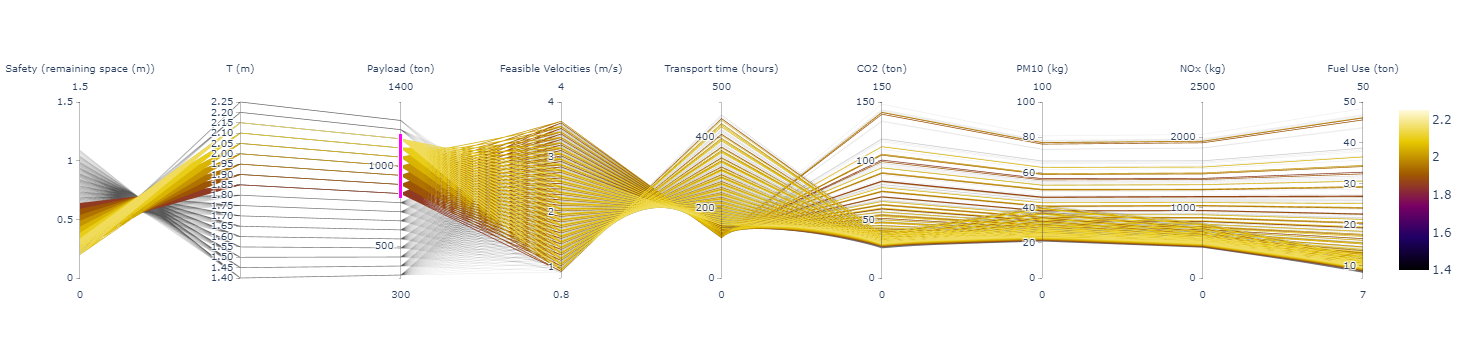

In [77]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = strategies_df['T'],
                   colorscale = 'Electric',
                   # colorscale = 'armyrose',
                   showscale = True,
                   cmin = 2.25,
                   cmax = 1.4),
        dimensions = list([
            dict(range = [0,1.5],
                 visible = True,
                 label = 'Safety (remaining space (m))', values = strategies_df['Safety (remaining space (m))']),
            dict(tickvals = [1.40,1.45,1.50,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,
                            1.95,2.00,2.05,2.10,2.15,2.20,2.25],
                 ticktext = ['1.40','1.45','1.50','1.55','1.60','1.65','1.70','1.75','1.80','1.85','1.90',
                            '1.95','2.00','2.05','2.10','2.15','2.20','2.25'],
                 label = "T (m)", values = strategies_df['T']),
            dict(range = [300,1400],
                 constraintrange = [800,1200],
                 label = "Payload (ton)", values = strategies_df['Payload_strategy_tanker (ton)']),
            dict(range = [0.8,4],
                 # constraintrange = [2,3.5],
                 label = "Feasible Velocities (m/s)", values = strategies_df['v_feasible_forT']),                       
             dict(range = [0,500],
                 label = 'Transport time (hours)', values = strategies_df['transport time (hours)']),
            dict(range = [0,150],
                 label = 'CO2 (ton)', values = strategies_df['CO2 (ton)']),
            dict(range = [0,100],                
                 label = 'PM10 (kg)', values = strategies_df['PM10 (kg)']),
            dict(range = [0,2500],                 
                 label = 'NOx (kg)', values = strategies_df['NOx (kg)']),
            dict(range = [7,50],
                 # constraintrange = [8,20],
                 label = "Fuel Use (ton)", values = strategies_df['Fuel Use (ton)']),
           
        ]),
    )
)
fig.show()

In [73]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/Strategies_and_policies.html")

In [ ]:
%%html
<iframe src="C:/interactiveCharts/parallel-coordinate-plot-plotly.html" width="800" height="600" title="parallel coordinate chart with plotly" style="border:none"></iframe>